In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# inspecting measurements
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [34]:
# Design a query to retrieve the last 12 months of precipitation data
from dateutil.relativedelta import relativedelta

#retrieving last 12 months
last_date = dt.date(2017, 8, 23)
last_twelve_months = last_date - relativedelta(months= 12)

#query design
last_twelve_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_twelve_months).\
    order_by(Measurement.date)

#data preparation
dates = [date[0] for date in last_twelve_data]
prcps =  [prcp[1] for prcp in last_twelve_data]

#creating a data frame
last_twelve_df = pd.DataFrame({
    "date": dates,
    "prcp": prcps
})

#data cleaning
last_twelve_df = last_twelve_df.dropna().set_index('date')

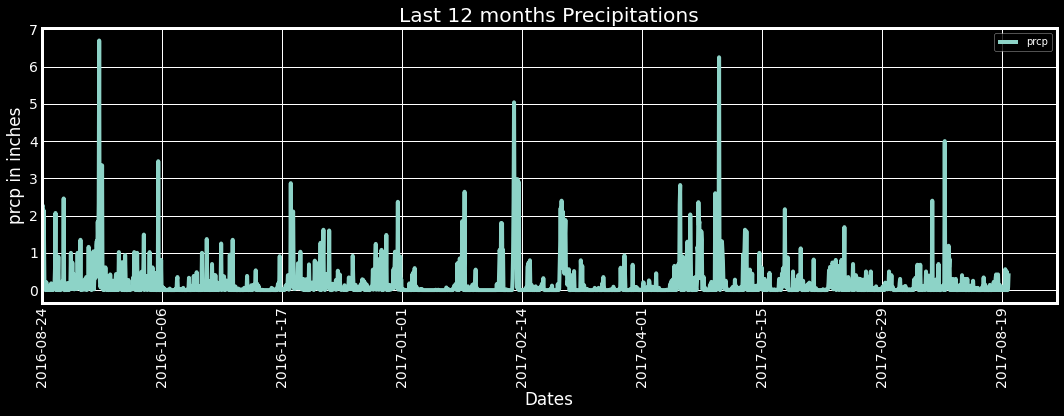

In [26]:
#EXPLORATORY GRAPH 1 
plt.style.use('dark_background')

last_twelve_df.plot(figsize=(15,6))

#precip, = plt.plot(prcp_data, label = 'Precipitation')

plt.title('Last 12 months Precipitations')
plt.ylabel('prcp in inches')
plt.xlabel('Dates')

plt.xticks(rotation = 90)
plt.xlim(0)
plt.legend(prop={'size': 10})

plt.grid(b = True)

plt.tight_layout()
plt.show()

In [28]:
#EXPLORATORY GRAPH2 

#LAST TWELVE MONTHS FOR 1 STATION
#query design
last_twelve_data2 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_twelve_months).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date)

#data preparation
dates = [date[0] for date in last_twelve_data2]
prcps =  [prcp[1] for prcp in last_twelve_data2]

#creating a data frame
last_twelve_df2 = pd.DataFrame({
    "date": dates,
    "prcp": prcps
})

#data cleaning
last_twelve_df2 = last_twelve_df2.dropna().sort_values('date')

In [29]:
#ticks labeling preparation for plotting 
initial_date = dt.date(2016,8,24)
dates = [str(initial_date)]
for i in range(10):
    initial_date += dt.timedelta(days = 35)
    dates.append(str(initial_date))
print(dates)

['2016-08-24', '2016-09-28', '2016-11-02', '2016-12-07', '2017-01-11', '2017-02-15', '2017-03-22', '2017-04-26', '2017-05-31', '2017-07-05', '2017-08-09']


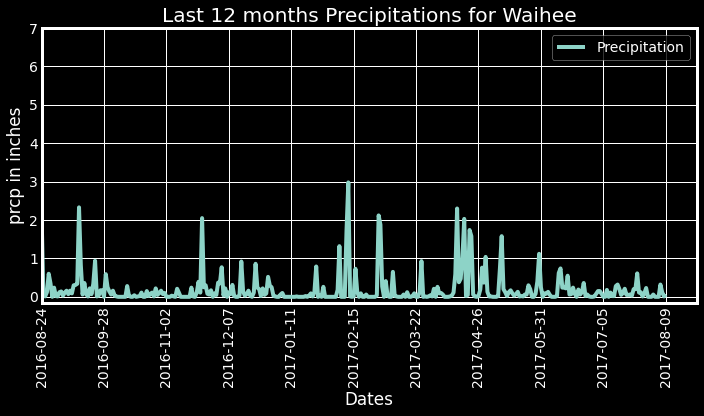

In [30]:
# plot last twelve months precipitations 
plt.style.use('dark_background')
max_prcp = last_twelve_df2['prcp'].max()

prcp_data = last_twelve_df2['prcp']

x_ticks = np.arange(0,len(last_twelve_df2),35)
yticks = np.arange(8)

plt.figure(figsize=(10,6))
precip, = plt.plot(prcp_data, label = 'Precipitation')

plt.title('Last 12 months Precipitations for Waihee')
plt.ylabel('prcp in inches')
plt.xlabel('Dates')

plt.yticks(yticks)
plt.xticks(x_ticks ,dates, rotation = 90)
plt.xlim(0)
plt.legend(handles = [precip], loc = 'upper right')

plt.grid(b = True)

plt.tight_layout()
plt.show()
#plt.savefig("output/last_year_prcp.png")

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_twelve_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#I choose to define "Activity" as "prcp" values > 0

#extracting data
conn = engine.connect()
data_set = pd.read_sql('SELECT * FROM measurement', conn) 

#dropin NaN and rows with no activity: prcp > 0
data_set = data_set.dropna()
data_nozeros = data_set[data_set.prcp > 0]

#counting
grouped_nozeros = data_nozeros.groupby('station').count().reset_index()

#extracting relevant columns and renaming apprpiately
station_counts = grouped_nozeros[['station', 'id']].rename({'id': 'count'}, axis = 1).\
    sort_values('count', ascending = False).reset_index().drop('index', axis = 1)
station_counts.head(10)

,station,count
0,USC00519281,1973
1,USC00516128,1937
2,USC00513117,1765
3,USC00519523,1191
4,USC00514830,1114
5,USC00519397,919
6,USC00511918,534
7,USC00518838,256
8,USC00517948,229


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
target_station = station_counts['station'][0]
target_data = data_set[data_set['station'].isin([target_station])][['tobs']]
print('This is the nunber of rows:', len(target_data))

#using panda
print('The lowest temperature recorded is:', target_data['tobs'].min())
print('The maximum temperature recorded is:', target_data['tobs'].max())
print('The average temperature recorded is:', round(target_data['tobs'].mean(),2))

This is the nunber of rows: 2772
The lowest temperature recorded is: 54.0
The maximum temperature recorded is: 85.0
The average temperature recorded is: 71.66


In [31]:
target_station

'USC00519281'

In [45]:
#same as before but using sql alchemy
max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()

min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()

print('The lowest temperature recorded is:', min_temp[0][1])
print('The maximum temperature recorded is:', max_temp[0][1])
print('The average temperature recorded is:', round(avg_temp[0][1], 2))

The lowest temperature recorded is: 54.0
The maximum temperature recorded is: 85.0
The average temperature recorded is: 71.66


In [53]:
# Choose the station with the highest number of temperature observations.
data_set.groupby('station').count().reset_index().sort_values('id',  ascending = False)

,station,id,date,prcp,tobs
6,USC00519281,2772,2772,2772,2772
1,USC00513117,2696,2696,2696,2696
7,USC00519397,2685,2685,2685,2685
8,USC00519523,2572,2572,2572,2572
3,USC00516128,2484,2484,2484,2484
2,USC00514830,1937,1937,1937,1937
0,USC00511918,1932,1932,1932,1932
4,USC00517948,683,683,683,683
5,USC00518838,342,342,342,342


In [42]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last12_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > last_twelve_months).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

tobs_data = [tobs[1] for tobs in station_last12_tobs]
tobs_data[:8]

[77.0, 80.0, 80.0, 75.0, 73.0, 78.0, 77.0, 78.0]

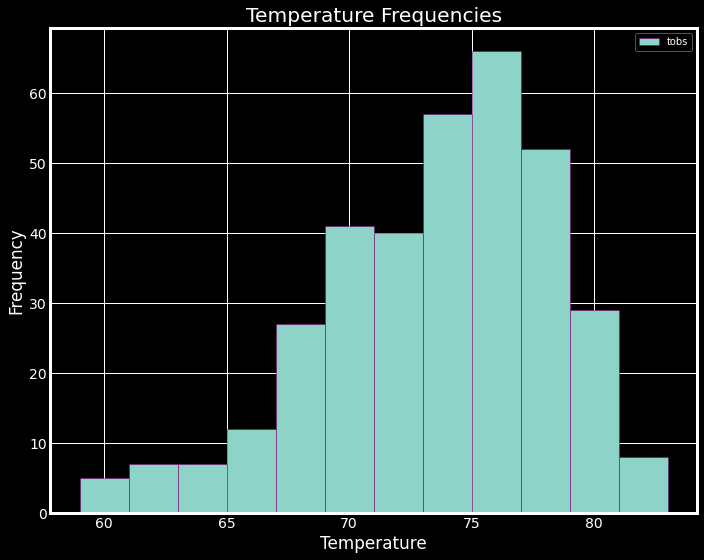

In [48]:
fig = plt.figure(figsize = (10,8))
plt.style.use('dark_background')

plt.title('Temperature Frequencies')
plt.xlabel("Temperature")
plt.ylabel('Frequency')

plt.hist(tobs_data, bins = 12, label = 'tobs', edgecolor = 'purple')

plt.grid(True)
plt.legend(prop={'size': 10})

plt.tight_layout()
plt.show()

In [155]:
#Query the dates and temperature observations of the most active station for the last year of data.
last_twelve_data2 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
        filter(Measurement.date > last_twelve_months).all()
last_twelve_data2[:5]

#data preparation
names = [name[0] for name in last_twelve_data2]
dates = [date[1] for date in last_twelve_data2]
tobs =  [tob[2] for tob in last_twelve_data2]



[('USC00519397', '2016-08-24', 79.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00519397', '2016-08-27', 77.0),
 ('USC00519397', '2016-08-28', 78.0)]

In [161]:
#creating a data frame
tobs_df = pd.DataFrame({
    "name": names,
    "tobs": tobs
})

counts_df =  tobs_df.groupby('name').count().sort_values('tobs', ascending = False)
target_station = counts_df.index[0]

max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()[0][1]

min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == target_station).all()

print('The lowest temperature recorded is:', min_temp[0][1])
print('The maximum temperature recorded is:', max_temp)
print('The average temperature recorded is:', round(avg_temp[0][1], 2))

The lowest temperature recorded is: 56.0
The maximum temperature recorded is: 87.0
The average temperature recorded is: 74.55


## Bonus Challenge Assignment

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-12-22', "2017-01-04")

[(62.0, 70.74418604651163, 78.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
